In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

In [2]:
spreadsheet_names = {
    #'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [3]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_cbg")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [4]:
dev_predictions_df = pd.read_table("results/before_20_sampled_lfs.tsv_dev.tsv")
dev_predictions_df.columns = ["model_predictions", "candidate_id"]
dev_predictions_df.head(2)

,model_predictions,candidate_id
0,0.070760,50527
1,0.280003,51441


In [5]:
model_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_predictions_df)
    [["curated_cbg", "model_predictions"]]
    .round(2)
)
model_predictions_df.head(2)

,curated_cbg,model_predictions
0,0.0,0.07
1,0.0,0.28


In [6]:
dev_all_predictions_df = pd.read_table("results/after_20_sampled_lfs.tsv_dev.tsv")
dev_all_predictions_df.columns = ["candidate_id", "model_predictions"]
dev_all_predictions_df.head(2)

,candidate_id,model_predictions
0,50527,0.380090
1,51441,0.455268


In [7]:
model_all_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_all_predictions_df, on="candidate_id")
    [["curated_cbg", "model_predictions"]]
    .round(2)
)
model_all_predictions_df.head(2)

,curated_cbg,model_predictions
0,0.0,0.38
1,0.0,0.46


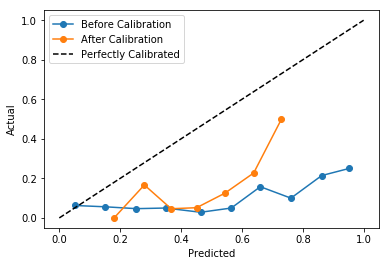

In [8]:
from sklearn.calibration import calibration_curve
cnn_y, cnn_x = calibration_curve(
    model_predictions_df.curated_cbg, 
    model_predictions_df.model_predictions, 
    n_bins=10
)

all_cnn_y, all_cnn_x = calibration_curve(
    model_predictions_df.curated_cbg, 
    model_all_predictions_df.model_predictions, 
    n_bins=10
)

plt.plot(cnn_x, cnn_y, marker='o', label="Before Calibration")
plt.plot(all_cnn_x, all_cnn_y, marker='o', label="After Calibration")

plt.plot([0,1], [0,1], color='black', linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()